# Distribution network assessment
*This notebook illustrates methods to assess the key variables of a distribution network.*  
*Use the virtual environment logproj_distribution.yml to run this notebook.*
***
Alessandro Tufano 2020

### Import packages

In [1]:
#suppress warnings
import warnings
warnings.filterwarnings("ignore")


# %% append functions path
import sys; sys.path.insert(0, '..') #add the above level with the package

# %% import packages
import pandas as pd
import matplotlib.figure
from IPython.display import display, HTML

#utilities
from logproj.P8_performanceAssessment.utilities_container import convertContainerISOcodeToTEUFEU
from logproj.P8_performanceAssessment.utilities_movements import movementStatistics

#demand assessment
from logproj.P8_performanceAssessment.client_demand_assessment import clientStatistics  
from logproj.P8_performanceAssessment.client_demand_assessment import paretoNodeClient
from logproj.P8_performanceAssessment.client_demand_assessment import violinPlantTerminal

#level of service
from logproj.P8_performanceAssessment.level_of_service_assessment import  checkPlannedActual
from logproj.P8_performanceAssessment.level_of_service_assessment import  travelTimedistribution
from logproj.P8_performanceAssessment.level_of_service_assessment import  calculateLoS

#product mix
from logproj.P8_performanceAssessment.product_mix_assessment import itemSharePieGraph
from logproj.P8_performanceAssessment.product_mix_assessment import itemLifeCycle

#vehicle stats
from logproj.P8_performanceAssessment.vehicle_assessment import D_voyageStatistics
from logproj.P8_performanceAssessment.vehicle_assessment import returnFigureVoyage
from logproj.P8_performanceAssessment.vehicle_assessment import graphClock

#terminal stats
from logproj.P8_performanceAssessment.terminal_assessment import E_terminalStatistics

#network stats
from logproj.P8_performanceAssessment.network_analysis import F_networkStatistics

#demand assessment
from logproj.P9_workloadPrediction.demand_assessment import getAdvanceInPlanning

#import utilities
from logproj.utilities import creaCartella




### Import data

In [2]:
# %% import data
from logproj.data_generator_distribution import generateDistributionData

#random generation of distribution data
D_nodes, D_parts, D_plants, D_mov = generateDistributionData()

In [3]:
#print nodes dataframe
display(HTML(D_nodes.to_html()))

,NODECODE,LATITUDE,LONGITUDE
0,0,41.690438,15.017185
0,1,41.641423,14.579298
0,2,41.427161,14.770750
0,3,41.695798,14.920676
0,4,41.585099,14.611218
0,5,41.743751,14.815119
0,6,41.817995,14.507608
0,7,41.650389,13.981322
0,8,41.858538,14.126430
0,9,41.753598,14.088160


In [4]:
#print parts dataframe
display(HTML(D_parts.to_html()))

,ITEMCODE,PRODUCT_FAMILY
0,0,PRODUCT_FAMILY 1
0,1,PRODUCT_FAMILY 2


In [5]:
#print plants dataframe
display(HTML(D_plants.to_html()))

,NODECODE,LATITUDE,LONGITUDE,listClient
0,PLANT,41.636135,14.379978,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24)"


In [6]:
#print movement dataframe
display(HTML(D_mov.to_html()))

,LOADING_NODE,LOADING_NODE_LATITUDE,LOADING_NODE_LONGITUDE,PTA_FROM,PTD_FROM,ATA_FROM,ATD_FROM,DISCHARGING_NODE,DISCHARGING_LATITUDE,DISCHARGING_LONGITUDE,PTA_TO,PTD_TO,ATA_TO,ATD_TO,ITEMCODE,PRODUCT_FAMILY,CLIENT,VEHICLE_CODE,VOYAGE_CODE,QUANTITY,TIMESTAMP_IN,PACKAGE_DESCRIPTION
0,23,41.533766,14.345362,2020-01-02 00:00:00.000000,2020-01-02 01:00:00.000000,2020-01-01 23:57:20.888201,2020-01-02 00:57:02.830752,5,41.743751,14.815119,2020-01-02 16:40:58.394783,2020-01-02 17:40:58.394783,2020-01-02 16:57:20.630642,2020-01-02 17:40:32.060020,1,PRODUCT_FAMILY 2,CLIENT 2,TRUCK 1,0,8.645434,2019-12-30 21:25:42.662650,TEU CONTAINER
0,12,41.641210,14.462968,2020-01-03 00:38:22.137885,2020-01-03 01:38:22.137885,2020-01-03 00:33:47.346623,2020-01-03 01:19:26.136447,4,41.585099,14.611218,2020-01-03 06:24:03.468070,2020-01-03 07:24:03.468070,2020-01-03 06:16:03.715470,2020-01-03 07:20:52.937095,0,PRODUCT_FAMILY 1,CLIENT 1,TRUCK 1,0,2.742074,2020-01-01 14:05:35.283308,FEU CONTAINER
0,21,41.558983,14.029682,2020-01-03 11:57:14.541453,2020-01-03 12:57:14.541453,2020-01-03 12:15:31.862747,2020-01-03 12:54:34.220466,10,41.910360,14.942609,2020-01-04 22:32:17.104739,2020-01-04 23:32:17.104739,2020-01-04 22:31:32.443953,2020-01-04 23:55:49.434241,0,PRODUCT_FAMILY 1,CLIENT 2,TRUCK 1,0,6.762935,2019-12-24 07:40:32.909316,FEU CONTAINER
0,14,41.508604,14.250159,2020-01-05 00:56:10.863723,2020-01-05 01:56:10.863723,2020-01-05 01:02:53.504920,2020-01-05 02:11:55.753721,8,41.858538,14.126430,2020-01-05 16:46:28.538870,2020-01-05 17:46:28.538870,2020-01-05 16:46:45.817899,2020-01-05 17:17:44.160375,0,PRODUCT_FAMILY 1,CLIENT 1,TRUCK 1,0,3.546651,2020-01-03 17:23:30.987496,TEU CONTAINER
0,20,41.631911,14.750575,2020-01-05 17:49:36.621711,2020-01-05 18:49:36.621711,2020-01-05 17:50:55.085076,2020-01-05 19:18:41.454317,9,41.753598,14.088160,2020-01-06 09:24:49.224604,2020-01-06 10:24:49.224604,2020-01-06 09:23:23.056274,2020-01-06 10:09:02.263357,0,PRODUCT_FAMILY 1,CLIENT 1,TRUCK 1,0,5.369077,2020-01-01 22:30:46.935944,TEU CONTAINER
0,2,41.427161,14.770750,2020-01-06 11:56:47.805446,2020-01-06 12:56:47.805446,2020-01-06 11:49:20.743947,2020-01-06 13:17:08.424985,23,41.533766,14.345362,2020-01-07 07:27:14.802683,2020-01-07 08:27:14.802683,2020-01-07 06:59:02.548187,2020-01-07 08:26:59.940120,0,PRODUCT_FAMILY 1,CLIENT 1,TRUCK 1,0,2.242727,2020-01-06 00:48:36.649413,FEU CONTAINER
0,11,41.688668,14.653675,2020-01-07 09:42:02.591771,2020-01-07 10:42:02.591771,2020-01-07 09:28:51.198165,2020-01-07 11:09:14.511262,9,41.753598,14.088160,2020-01-07 23:24:10.916378,2020-01-08 00:24:10.916378,2020-01-07 23:37:05.498908,2020-01-07 23:55:43.641376,1,PRODUCT_FAMILY 2,CLIENT 1,TRUCK 1,0,1.598866,2020-01-03 21:53:05.023337,TEU CONTAINER
0,14,41.508604,14.250159,2020-01-08 01:37:26.130872,2020-01-08 02:37:26.130872,2020-01-08 01:16:20.393205,2020-01-08 02:49:38.343614,20,41.631911,14.750575,2020-01-08 23:37:25.586067,2020-01-09 00:37:25.586067,2020-01-08 23:17:22.677856,2020-01-09 00:34:30.716323,1,PRODUCT_FAMILY 2,CLIENT 2,TRUCK 1,0,5.295155,2020-01-07 15:02:40.174740,TEU CONTAINER
0,4,41.585099,14.611218,2020-01-09 01:07:29.289298,2020-01-09 02:07:29.289298,2020-01-09 01:02:18.599669,2020-01-09 01:58:22.866619,19,41.934354,14.274380,2020-01-09 17:14:03.513701,2020-01-09 18:14:03.513701,2020-01-09 17:10:43.776527,2020-01-09 18:38:19.495170,0,PRODUCT_FAMILY 1,CLIENT 2,TRUCK 1,0,9.252379,2020-01-02 10:58:20.829274,TEU CONTAINER
0,1,41.641423,14.579298,2020-01-09 19:58:49.714386,2020-01-09 20:58:49.714386,2020-01-09 20:04:45.900627,2020-01-09 20:46:27.000084,4,41.585099,14.611218,2020-01-09 23:01:42.886136,2020-01-10 00:01:42.886136,2020-01-09 23:31:09.138148,2020-01-09 23:59:51.988809,0,PRODUCT_FAMILY 1,CLIENT 1,TRUCK 1,0,8.768798,2020-01-01 10:31:15.228141,TEU CONTAINER


### Set data fields  
Specify the content of each column of the input data.

In [7]:
string_casestudy = 'TOY_DATA'


movementColumns= {
           'timevariable':'TIMESTAMP_IN', #colonna obbligatoria con i timestamp per ogni movimento
           'capacityField':'QUANTITY', #colonna obblicatoria che identifica la quantita' movimentata
           
           'specificItemfield':'ITEMCODE', #colonna che indica il codice di ogni singolo prodotto movimentato (ciclo di vita)
           'itemfamily' : 'PRODUCT_FAMILY', #colonna che indica la famiglia di prodotto movimentato (per market share)
           'packageFamily':'PACKAGE_DESCRIPTION', #colonna che identifica la tipologia di package utilizzato
           
           'clientfield':'DISCHARGING_NODE', # colonna che identifica il cliente servito
           'operatorfield':'CLIENT', #colonna che identifica l'operatore
           
           'vehiclefield':'VEHICLE_CODE', #colonna che identifica il veicolo utilizzato
           'voyagefield':'VOYAGE_CODE', #colonna che identifica il codice del singolo viaggio
           
           
           'terminalfieldFrom':'LOADING_NODE', #colonna che identifica il nodo di carico
           'terminalfieldto':'DISCHARGING_NODE', #colonna che identifica il nodo di scarico
  
           }

timeColumns = {'loadingpta':'PTA_FROM',
               'loadingptd':'PTD_FROM', 
               'dischargingpta':'PTA_TO', 
               'dischargingptd':'PTD_TO', 
               'loadingata':'ATA_FROM', 
               'loadingatd':'ATD_FROM', 
               'dischargingata':'ATA_TO', 
               'dischargingatd':'ATD_TO'
               
               }

joinContainerToMov=False #join hu table and movement table on fields
codeFieldcontainerCodeHu='_id'
codeFieldcontainerCodeMov=''

### Create folder hierarchy

In [1]:
# %% create folder hierarchy
pathResults = 'C:\\Users\\aletu\\desktop'
_, root_path = creaCartella(pathResults,f"{string_casestudy}_results")
_, path_results = creaCartella(root_path,f"P8_networkAssessment")

NameError: name 'creaCartella' is not defined

### Preprocess data

In [9]:
'''
#convert timestamps
D_mov = mdb.convertMongoToPandasDate(D_mov, 'TIMESTAMP_IN')
for twColumn in set(timeColumns.values()):
    D_mov = mdb.convertMongoToPandasDate(D_mov, f"{twColumn}")
    
        
# add teu size
#Aggiungo informazione su TEU/FEU
if len(D_hu)>0:
    D_hu =convertContainerISOcodeToTEUFEU(D_hu)
if joinContainerToMov:
    D_mov=pd.merge(D_hu, D_mov, left_on=[codeFieldcontainerCodeHu],right_on=[codeFieldcontainerCodeMov],how='right',suffixes=('_y',''))
    D_mov=D_mov.rename(columns={'_id_y':'HU_CODE'}) # se non ho matchato sugli id, vado a rinominare l'id degli hu
    D_mov.drop(list(D_mov.filter(regex='_y$')), axis=1, inplace=True) #rimuovo colonne doppie 
'''

'\n#convert timestamps\nD_mov = mdb.convertMongoToPandasDate(D_mov, \'TIMESTAMP_IN\')\nfor twColumn in set(timeColumns.values()):\n    D_mov = mdb.convertMongoToPandasDate(D_mov, f"{twColumn}")\n    \n        \n# add teu size\n#Aggiungo informazione su TEU/FEU\nif len(D_hu)>0:\n    D_hu =convertContainerISOcodeToTEUFEU(D_hu)\nif joinContainerToMov:\n    D_mov=pd.merge(D_hu, D_mov, left_on=[codeFieldcontainerCodeHu],right_on=[codeFieldcontainerCodeMov],how=\'right\',suffixes=(\'_y\',\'\'))\n    D_mov=D_mov.rename(columns={\'_id_y\':\'HU_CODE\'}) # se non ho matchato sugli id, vado a rinominare l\'id degli hu\n    D_mov.drop(list(D_mov.filter(regex=\'_y$\')), axis=1, inplace=True) #rimuovo colonne doppie \n'

## Global analysis  
Definition of the global statistics on the entities of the input dataset.

In [10]:
_, current_path = creaCartella(path_results,f"Global Statistics")
D_global = movementStatistics(D_mov,capacityField = movementColumns['capacityField']) 
D_global.to_excel(current_path+'\\movement_stats.xlsx') 
display(HTML(D_global.to_html()))

Cartella Global Statistics già esistente


,VALUE,ACCURACY
COUNT.LOADING_NODE,24,"(1.0, 1.0)"
COUNT.LOADING_NODE_LATITUDE,24,"(1.0, 1.0)"
SUM.LOADING_NODE_LATITUDE,4169.16,"(1.0, 1.0)"
COUNT.LOADING_NODE_LONGITUDE,24,"(1.0, 1.0)"
SUM.LOADING_NODE_LONGITUDE,1452.62,"(1.0, 1.0)"
COUNT.PTA_FROM,100,"(1.0, 1.0)"
N.OF.DAYS.PTA_FROM,67,"(1.0, 1.0)"
FIRST.DAY.PTA_FROM,2020-01-02,"(1.0, 1.0)"
LAST.DAY.PTA_FROM,2020-03-15,"(1.0, 1.0)"
COUNT.PTD_FROM,100,"(1.0, 1.0)"


## Planning efficiency analysis

Cartella Planning Analysis già esistente


,VALUE,ACCURACY
ADVANCE_PLANNING_MEAN,6.25818,"((1.0, 1.0), 100)"
ADVANCE_PLANNING_STD,6.89622,"((1.0, 1.0), 100)"
SERIES,"0 2.106944 0 1.438889 0 10.177778 0 1.313889 0 3.804167 ... 0 1.625694 0 1.662500 0 8.220833 0 3.243056 0 23.371528 Length: 100, dtype: float64","((1.0, 1.0), 100)"


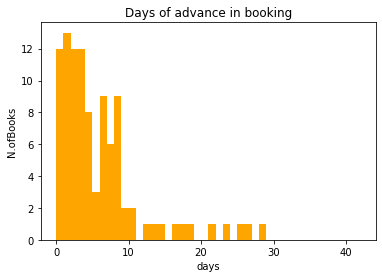

In [11]:
#calculate the gap between the order and the esecution day

if 'loadingpta' in  timeColumns.keys():
    _, current_path = creaCartella(path_results,f"Planning Analysis")
    output_figure, D_global  = getAdvanceInPlanning(D_mov,loadingptafield=timeColumns['loadingpta'])
    
    #save figure
    for key in output_figure.keys():
        if isinstance(output_figure[key], matplotlib.figure.Figure):
            output_figure[key].savefig(current_path+f"\\{key}.png")
    
    #save dataframe
    D_global.to_excel(current_path+'\\planning_stats.xlsx') 
    display(HTML(D_global.to_html()))
    

## Product demand share

Cartella Product Analysis già esistente


,PRODUCT_FAMILY,Quantity,accuracy
0,PRODUCT_FAMILY 1,53,"(1.0, 1.0)"
1,PRODUCT_FAMILY 2,47,"(1.0, 1.0)"


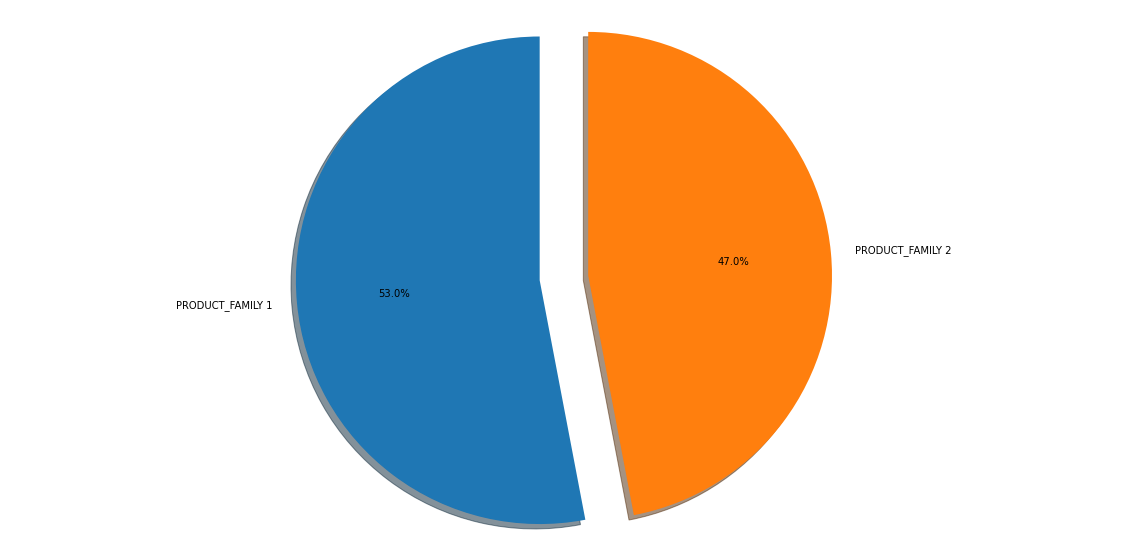

In [12]:
if 'itemfamily' in  movementColumns.keys():
    #se ho una indicazione sulle famiglie di prodotto posso realizzare un'analisi
    #della quota di mercato
    
    _, current_path = creaCartella(path_results,f"Product Analysis")
    figPieChartItem, df_demandProductShare = itemSharePieGraph(D_mov,
                                                               capacityField = movementColumns['capacityField'],
                                                               itemfield=movementColumns['itemfamily'])
    
    #save figure
    figPieChartItem.savefig(current_path+'\\demandProductShare.png')
    
    #save dataframe
    df_demandProductShare.to_excel(current_path+'\\demandProductShare.xlsx')
    display(HTML(df_demandProductShare.to_html()))
    

## Travel time analysis

### Provisional data

Cartella Travel Time Analysis già esistente
Cartella PROVISIONAL già esistente


,U_L_BOUND,TIME_MEAN,TIME_STD,accuracy
0,upperBound,0.645806,0.370050,"(1.0, 1.0)"
0,lowerBound,0.579868,0.362056,"(1.0, 1.0)"


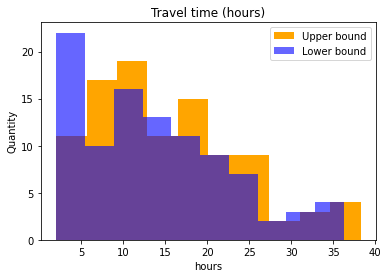

In [13]:
if all([field in timeColumns.keys() for field in ['loadingpta','loadingptd','dischargingpta', 'dischargingptd' ]]): 
    #se ho tutte le finestre temporali pianificate analizzo il caso PROVISIONAL
    
    _, current_path = creaCartella(path_results,f"Travel Time Analysis")
    _, current_path_actual = creaCartella(current_path,f"PROVISIONAL")  

    imageResults, df_traveltime = travelTimedistribution(D_mov,
                                           capacityField=movementColumns['capacityField'],
                                           loadingTA=timeColumns['loadingpta'],
                                           loadingTD=timeColumns['loadingptd'],
                                           dischargingTA=timeColumns['dischargingpta'],
                                           dischargingTD=timeColumns['dischargingptd'],
                           )
    #save figure
    for key in imageResults.keys():
        imageResults[key].savefig(current_path_actual+f"\\{key}.png")
    
    #save dataframe
    df_traveltime.to_excel(current_path_actual+'\\movementsTravelTime.xlsx')
    display(HTML(df_traveltime.to_html()))
    

### Actual data

Cartella Travel Time Analysis già esistente
Cartella ACTUAL già esistente


,U_L_BOUND,TIME_MEAN,TIME_STD,accuracy
0,upperBound,0.644035,0.370639,"(1.0, 1.0)"
0,lowerBound,0.567242,0.365136,"(1.0, 1.0)"


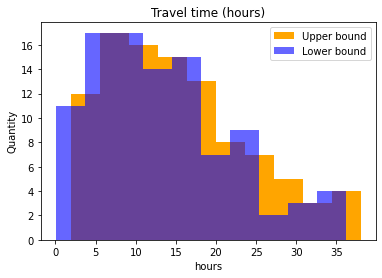

In [14]:
if all([field in timeColumns.keys() for field in ['loadingata','loadingatd','dischargingata', 'dischargingatd' ]]): 
    #se ho tutte le finestre temporali attuali analizzo il caso PROVISIONAL
    
    _, current_path = creaCartella(path_results,f"Travel Time Analysis")
    _, current_path_actual = creaCartella(current_path,f"ACTUAL")  

    imageResults, df_traveltime = travelTimedistribution(D_mov,
                                           capacityField=movementColumns['capacityField'],
                                           loadingTA=timeColumns['loadingata'],
                                           loadingTD=timeColumns['loadingatd'],
                                           dischargingTA=timeColumns['dischargingata'],
                                           dischargingTD=timeColumns['dischargingatd'],
                           )
    
    for key in imageResults.keys():
        imageResults[key].savefig(current_path_actual+f"\\{key}.png")
    
    #save dataframe
    df_traveltime.to_excel(current_path_actual+'\\movementsTravelTime.xlsx')
    display(HTML(df_traveltime.to_html()))

## Level of Service

Cartella Travel Time Analysis già esistente


,0,1
0,1.0,1.0


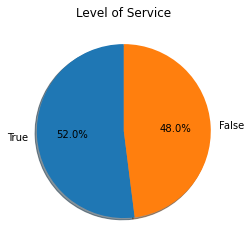

In [15]:
if all( column in timeColumns.keys() for column in ['loadingptd','dischargingpta',
                                                        'loadingatd','dischargingata']):
    _, current_path = creaCartella(path_results,f"Travel Time Analysis")
    output_figure, coverages=   calculateLoS(D_mov,
                               capacityField=movementColumns['capacityField'],
                                timeColumns=timeColumns
                               )
    for key in output_figure.keys():
        output_figure[key].savefig(current_path+f"\\{key}.png")
    
    #save dataframe
    coverages.to_excel(current_path+f"\\Level_of_service_coverages.xlsx")
    display(HTML(coverages.to_html()))

## Product lifecycle

Cartella Product Life Cycle Analysis già esistente
**** DEFINISCO D MOV IN/OUT ****
**** DEFINISCO D MOV IN/OUT ****


,index,LOADING_NODE,LOADING_NODE_LATITUDE,LOADING_NODE_LONGITUDE,PTA_FROM,PTD_FROM,ATA_FROM,ATD_FROM,DISCHARGING_NODE,DISCHARGING_LATITUDE,DISCHARGING_LONGITUDE,PTA_TO,PTD_TO,ATA_TO,ATD_TO,ITEMCODE,PRODUCT_FAMILY,CLIENT,VEHICLE_CODE,VOYAGE_CODE,QUANTITY,TIMESTAMP_IN,PACKAGE_DESCRIPTION,accuracy
0,0,12,41.641210,14.462968,2020-01-03 00:38:22.137885,2020-01-03 01:38:22.137885,2020-01-03 00:33:47.346623,2020-01-03 01:19:26.136447,4,41.585099,14.611218,2020-01-03 06:24:03.468070,2020-01-03 07:24:03.468070,2020-01-03 06:16:03.715470,2020-01-03 07:20:52.937095,0,PRODUCT_FAMILY 1,CLIENT 1,TRUCK 1,0,2.742074,2020-01-01 14:05:35.283308,FEU CONTAINER,"(1.0, 1.0)"
1,0,21,41.558983,14.029682,2020-01-03 11:57:14.541453,2020-01-03 12:57:14.541453,2020-01-03 12:15:31.862747,2020-01-03 12:54:34.220466,10,41.910360,14.942609,2020-01-04 22:32:17.104739,2020-01-04 23:32:17.104739,2020-01-04 22:31:32.443953,2020-01-04 23:55:49.434241,0,PRODUCT_FAMILY 1,CLIENT 2,TRUCK 1,0,6.762935,2019-12-24 07:40:32.909316,FEU CONTAINER,"(1.0, 1.0)"
2,0,14,41.508604,14.250159,2020-01-05 00:56:10.863723,2020-01-05 01:56:10.863723,2020-01-05 01:02:53.504920,2020-01-05 02:11:55.753721,8,41.858538,14.126430,2020-01-05 16:46:28.538870,2020-01-05 17:46:28.538870,2020-01-05 16:46:45.817899,2020-01-05 17:17:44.160375,0,PRODUCT_FAMILY 1,CLIENT 1,TRUCK 1,0,3.546651,2020-01-03 17:23:30.987496,TEU CONTAINER,"(1.0, 1.0)"
3,0,20,41.631911,14.750575,2020-01-05 17:49:36.621711,2020-01-05 18:49:36.621711,2020-01-05 17:50:55.085076,2020-01-05 19:18:41.454317,9,41.753598,14.088160,2020-01-06 09:24:49.224604,2020-01-06 10:24:49.224604,2020-01-06 09:23:23.056274,2020-01-06 10:09:02.263357,0,PRODUCT_FAMILY 1,CLIENT 1,TRUCK 1,0,5.369077,2020-01-01 22:30:46.935944,TEU CONTAINER,"(1.0, 1.0)"
4,0,2,41.427161,14.770750,2020-01-06 11:56:47.805446,2020-01-06 12:56:47.805446,2020-01-06 11:49:20.743947,2020-01-06 13:17:08.424985,23,41.533766,14.345362,2020-01-07 07:27:14.802683,2020-01-07 08:27:14.802683,2020-01-07 06:59:02.548187,2020-01-07 08:26:59.940120,0,PRODUCT_FAMILY 1,CLIENT 1,TRUCK 1,0,2.242727,2020-01-06 00:48:36.649413,FEU CONTAINER,"(1.0, 1.0)"
5,0,4,41.585099,14.611218,2020-01-09 01:07:29.289298,2020-01-09 02:07:29.289298,2020-01-09 01:02:18.599669,2020-01-09 01:58:22.866619,19,41.934354,14.274380,2020-01-09 17:14:03.513701,2020-01-09 18:14:03.513701,2020-01-09 17:10:43.776527,2020-01-09 18:38:19.495170,0,PRODUCT_FAMILY 1,CLIENT 2,TRUCK 1,0,9.252379,2020-01-02 10:58:20.829274,TEU CONTAINER,"(1.0, 1.0)"
6,0,1,41.641423,14.579298,2020-01-09 19:58:49.714386,2020-01-09 20:58:49.714386,2020-01-09 20:04:45.900627,2020-01-09 20:46:27.000084,4,41.585099,14.611218,2020-01-09 23:01:42.886136,2020-01-10 00:01:42.886136,2020-01-09 23:31:09.138148,2020-01-09 23:59:51.988809,0,PRODUCT_FAMILY 1,CLIENT 1,TRUCK 1,0,8.768798,2020-01-01 10:31:15.228141,TEU CONTAINER,"(1.0, 1.0)"
7,0,0,41.690438,15.017185,2020-01-10 02:33:25.203394,2020-01-10 03:33:25.203394,2020-01-10 02:29:14.851011,2020-01-10 03:32:56.413027,5,41.743751,14.815119,2020-01-10 08:06:19.501476,2020-01-10 09:06:19.501476,2020-01-10 07:30:20.974605,2020-01-10 09:11:53.252999,0,PRODUCT_FAMILY 1,CLIENT 1,TRUCK 1,0,4.235613,2020-01-06 02:53:37.537318,FEU CONTAINER,"(1.0, 1.0)"
8,0,2,41.427161,14.770750,2020-01-10 09:41:17.534916,2020-01-10 10:41:17.534916,2020-01-10 09:35:13.208589,2020-01-10 10:25:55.108725,2,41.427161,14.770750,2020-01-10 10:41:17.534916,2020-01-10 11:41:17.534916,2020-01-10 10:55:38.247323,2020-01-10 11:37:30.913979,0,PRODUCT_FAMILY 1,CLIENT 1,TRUCK 1,0,5.360177,2020-01-02 02:24:45.142008,TEU CONTAINER,"(1.0, 1.0)"
9,0,11,41.688668,14.653675,2020-01-11 06:06:11.612579,2020-01-11 07:06:11.612579,2020-01-11 06:31:11.082011,2020-01-11 07:29:47.489773,5,41.743751,14.815119,2020-01-11 10:56:04.135752,2020-01-11 11:56:04.135752,2020-01-11 10:46:34.376130,2020-01-11 12:31:26.851520,0,PRODUCT_FAMILY 1,CLIENT 1,TRUCK 1,0,3.256362,2020-01-09 04:44:19.526886,FEU CONTAINER,"(1.0, 1.0)"


,index,LOADING_NODE,LOADING_NODE_LATITUDE,LOADING_NODE_LONGITUDE,PTA_FROM,PTD_FROM,ATA_FROM,ATD_FROM,DISCHARGING_NODE,DISCHARGING_LATITUDE,DISCHARGING_LONGITUDE,PTA_TO,PTD_TO,ATA_TO,ATD_TO,ITEMCODE,PRODUCT_FAMILY,CLIENT,VEHICLE_CODE,VOYAGE_CODE,QUANTITY,TIMESTAMP_IN,PACKAGE_DESCRIPTION,accuracy
0,0,23,41.533766,14.345362,2020-01-02 00:00:00.000000,2020-01-02 01:00:00.000000,2020-01-01 23:57:20.888201,2020-01-02 00:57:02.830752,5,41.743751,14.815119,2020-01-02 16:40:58.394783,2020-01-02 17:40:58.394783,2020-01-02 16:57:20.630642,2020-01-02 17:40:32.060020,1,PRODUCT_FAMILY 2,CLIENT 2,TRUCK 1,0,8.645434,2019-12-30 21:25:42.662650,TEU CONTAINER,"(1.0, 1.0)"
1,0,11,41.688668,14.653675,2020-01-07 09:42:02.591771,2020-01-07 10:42:02.591771,2020-01-07 09:28:51.198165,2020-01-07 11:09:14.511262,9,41.753598,14.088160,2020-01-07 23:24:10.916378,2020-01-08 00:24:10.916378,2020-01-07 23:37:05.498908,2020-01-07 23:55:43.641376,1,PRODUCT_FAMILY 2,CLIENT 1,TRUCK 1,0,1.598866,2020-01-03 21:53:05.023337,TEU CONTAINER,"(1.0, 1.0)"
2,0,14,41.508604,14.250159,2020-01-08 01:37:26.130872,2020-01-08 02:37:26.130872,2020-01-08 01:16:20.393205,2020-01-08 02:49:38.343614,20,41.631911,14.750575,2020-01-08 23:37:25.586067,2020-01-09 00:37:25.586067,2020-01-08 23:17:22.677856,2020-01-09 00:34:30.716323,1,PRODUCT_FAMILY 2,CLIENT 2,TRUCK 1,0,5.295155,2020-01-07 15:02:40.174740,TEU CONTAINER,"(1.0, 1.0)"
3,0,3,41.695798,14.920676,2020-01-10 13:24:08.793542,2020-01-10 14:24:08.793542,2020-01-10 13:15:41.986311,2020-01-10 14:31:09.087787,14,41.508604,14.250159,2020-01-11 04:26:15.737212,2020-01-11 05:26:15.737212,2020-01-11 04:16:42.719815,2020-01-11 05:29:52.515110,1,PRODUCT_FAMILY 2,CLIENT 1,TRUCK 1,0,8.645434,2020-01-07 21:18:07.466143,TEU CONTAINER,"(1.0, 1.0)"
4,0,18,41.881926,15.043466,2020-01-11 15:57:55.821316,2020-01-11 16:57:55.821316,2020-01-11 15:48:08.544150,2020-01-11 17:02:17.745561,9,41.753598,14.088160,2020-01-12 17:44:10.876821,2020-01-12 18:44:10.876821,2020-01-12 17:54:30.592719,2020-01-12 18:29:55.248238,1,PRODUCT_FAMILY 2,CLIENT 1,TRUCK 1,0,1.382330,2020-01-02 16:24:10.524254,TEU CONTAINER,"(1.0, 1.0)"
5,0,14,41.508604,14.250159,2020-01-13 01:28:58.070181,2020-01-13 02:28:58.070181,2020-01-13 01:30:28.586707,2020-01-13 02:46:03.909738,12,41.641210,14.462968,2020-01-13 12:49:06.635754,2020-01-13 13:49:06.635754,2020-01-13 12:33:03.699965,2020-01-13 13:47:11.890933,1,PRODUCT_FAMILY 2,CLIENT 1,TRUCK 1,0,5.465048,2020-01-05 05:13:31.458100,FEU CONTAINER,"(1.0, 1.0)"
6,0,21,41.558983,14.029682,2020-01-14 03:15:10.882799,2020-01-14 04:15:10.882799,2020-01-14 03:20:28.923805,2020-01-14 04:21:13.628441,10,41.910360,14.942609,2020-01-15 07:34:03.555048,2020-01-15 08:34:03.555048,2020-01-15 07:28:57.745806,2020-01-15 08:37:20.963546,1,PRODUCT_FAMILY 2,CLIENT 2,TRUCK 1,0,6.667935,2020-01-12 20:45:53.984114,TEU CONTAINER,"(1.0, 1.0)"
7,0,14,41.508604,14.250159,2020-01-16 19:27:30.233948,2020-01-16 20:27:30.233948,2020-01-16 19:43:22.172173,2020-01-16 20:41:41.238730,18,41.881926,15.043466,2020-01-17 21:35:37.286404,2020-01-17 22:35:37.286404,2020-01-17 21:52:28.702728,2020-01-17 22:36:16.882834,1,PRODUCT_FAMILY 2,CLIENT 2,TRUCK 1,0,2.997288,2020-01-10 13:15:00.884618,TEU CONTAINER,"(1.0, 1.0)"
8,0,11,41.688668,14.653675,2020-01-17 22:58:29.203594,2020-01-17 23:58:29.203594,2020-01-17 22:45:26.414009,2020-01-17 23:37:57.564847,21,41.558983,14.029682,2020-01-19 00:50:46.938167,2020-01-19 01:50:46.938167,2020-01-19 00:53:18.995254,2020-01-19 01:55:06.303139,1,PRODUCT_FAMILY 2,CLIENT 1,TRUCK 1,0,9.356582,2020-01-10 12:27:54.369090,TEU CONTAINER,"(1.0, 1.0)"
9,0,0,41.690438,15.017185,2020-01-20 13:40:04.991682,2020-01-20 14:40:04.991682,2020-01-20 13:28:56.696653,2020-01-20 14:49:19.841135,15,41.888982,14.384893,2020-01-21 11:45:18.841687,2020-01-21 12:45:18.841687,2020-01-21 11:36:52.956552,2020-01-21 12:58:31.153668,1,PRODUCT_FAMILY 2,CLIENT 1,TRUCK 1,1,7.383588,2020-01-14 10:22:45.113083,TEU CONTAINER,"(1.0, 1.0)"


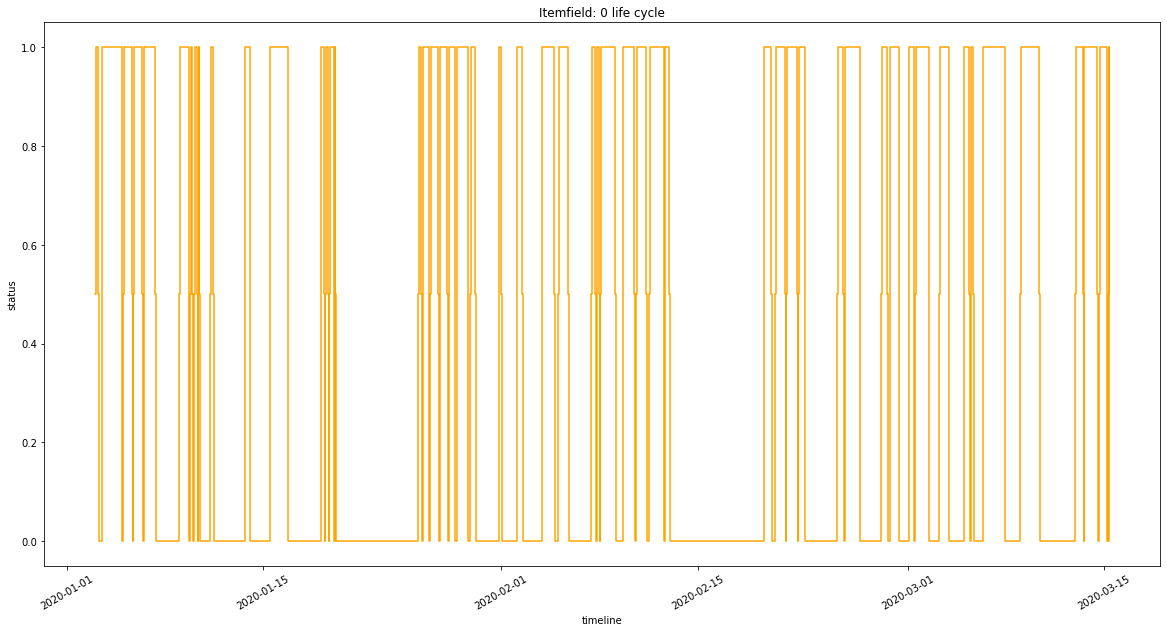

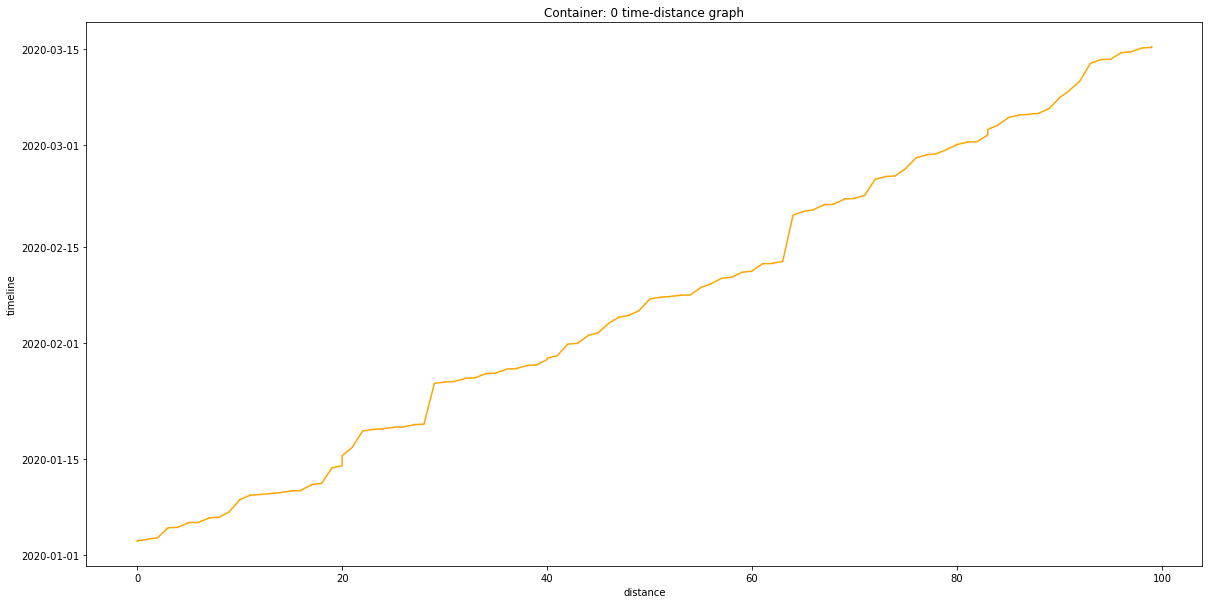

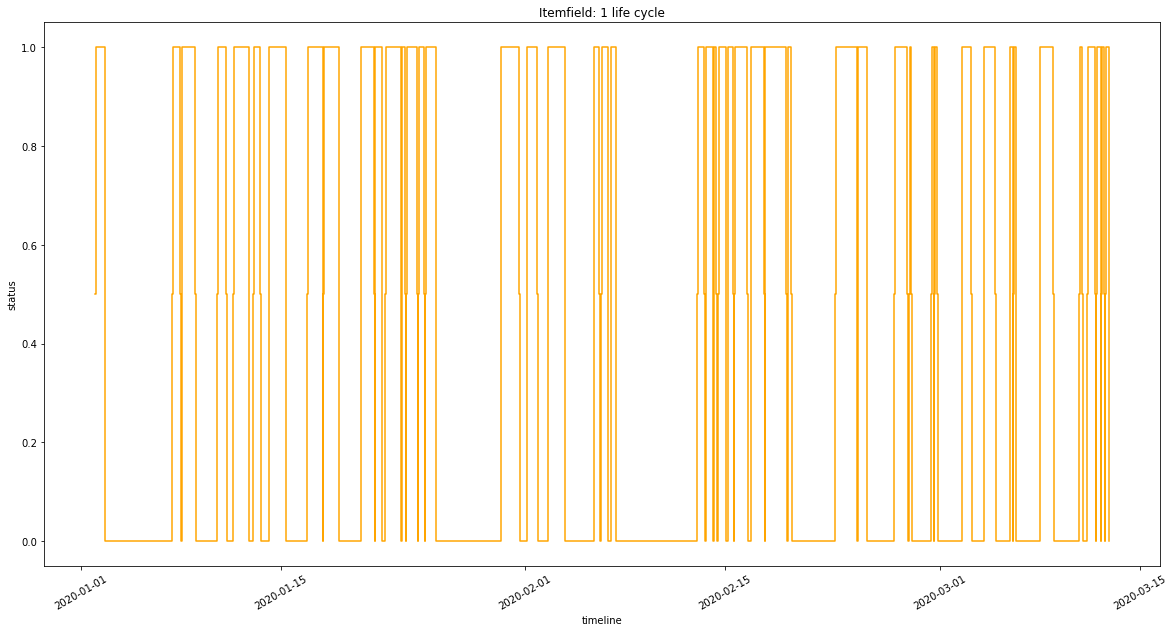

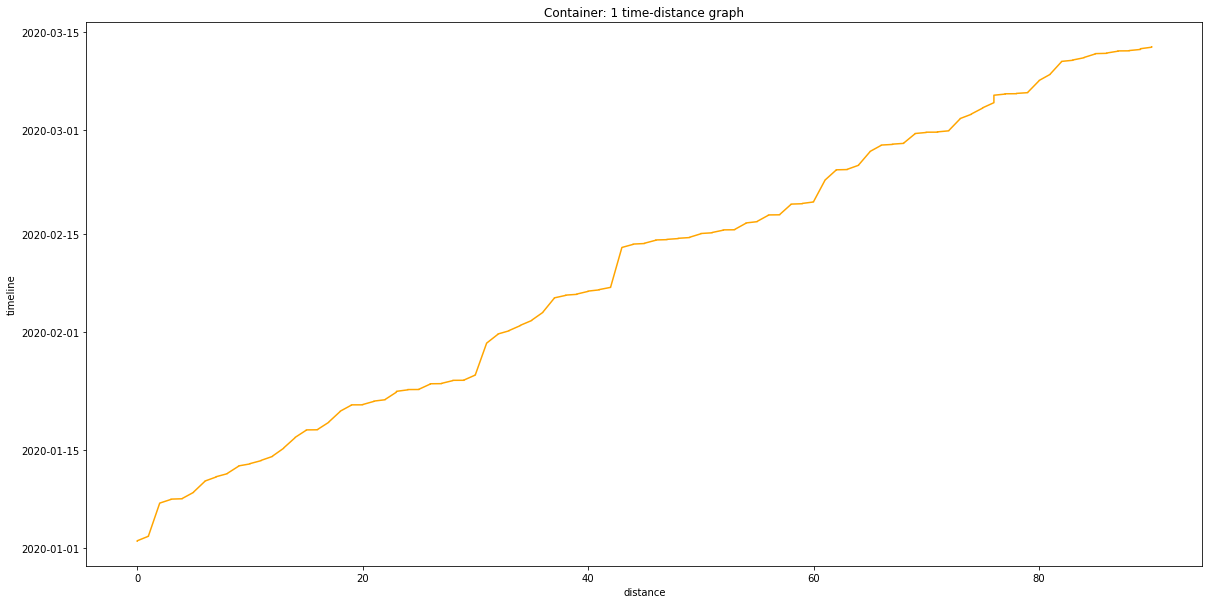

In [16]:
if all([field in movementColumns.keys() for field in ['terminalfieldFrom','terminalfieldto','specificItemfield']]):
    _, current_path = creaCartella(path_results,f"Product Life Cycle Analysis")
    
    imageResults, df_results = itemLifeCycle(D_mov,itemfield=movementColumns['specificItemfield'], 
                  locationfrom=movementColumns['terminalfieldFrom'],
                  locationto=movementColumns['terminalfieldto'],
                  capacityField=movementColumns['capacityField'],
                  timeColumns=timeColumns,
                  sortTimefield='PTA_FROM',
                  numItemTosave=5)
    
    
    

    for key in imageResults.keys():
        imageResults[key].savefig(current_path+f"\\{key}.png")
        
    # salvo dataframe
    for key in df_results.keys():
        df_results[key].to_excel(current_path+f"\\{key}.xlsx")
        display(HTML(df_results[key].to_html()))

## Client statistics

Cartella Client Analysis già esistente


,DISCHARGING_NODE,FEU CONTAINER,TEU CONTAINER,TotalOrders,accuracy
0,0,1.0,3.0,4,"(1.0, 1.0)"
1,1,1.0,3.0,4,"(1.0, 1.0)"
2,2,0.0,2.0,2,"(1.0, 1.0)"
3,3,1.0,2.0,3,"(1.0, 1.0)"
4,4,6.0,3.0,9,"(1.0, 1.0)"
5,5,6.0,2.0,8,"(1.0, 1.0)"
6,6,1.0,2.0,3,"(1.0, 1.0)"
7,7,1.0,3.0,4,"(1.0, 1.0)"
8,8,3.0,2.0,5,"(1.0, 1.0)"
9,9,2.0,4.0,6,"(1.0, 1.0)"


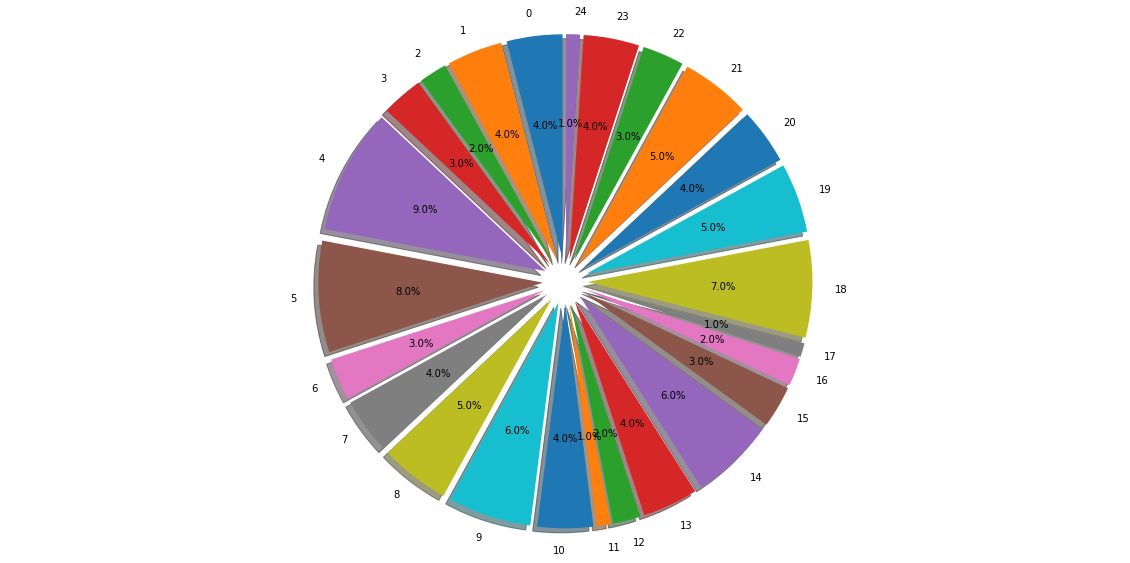

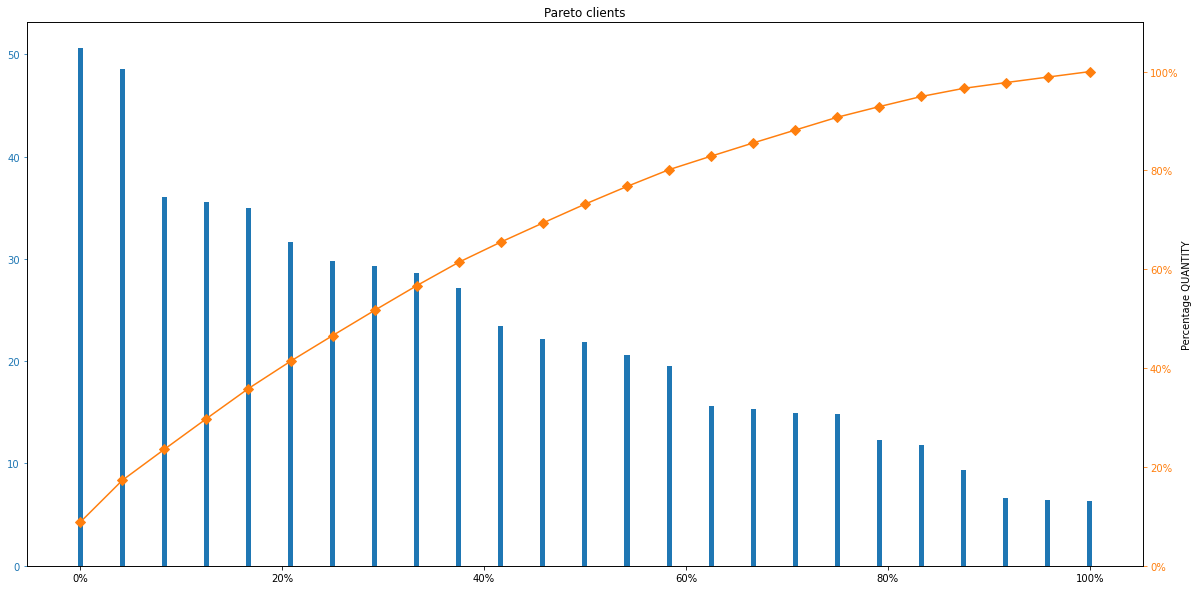

In [17]:
#represent the share of each client and the pareto curve
if all([field in movementColumns.keys() for field in ['clientfield','packageFamily']]):        
    _, current_path = creaCartella(path_results,f"Client Analysis")
    
    imageResults, df_results = clientStatistics(D_mov, 
                           clientfield=movementColumns['clientfield'],
                           itemfamily=movementColumns['packageFamily'],
                           capacityfield=movementColumns['capacityField'])
    
    #salvo immagini
    for key in imageResults.keys():
            imageResults[key].savefig(current_path+f"\\{key}.png")
            
    # salvo dataframe
    df_results.to_excel(current_path+f"\\clientStatistics.xlsx")
    display(HTML(df_results.to_html()))

,0,1
0,1.0,1.0


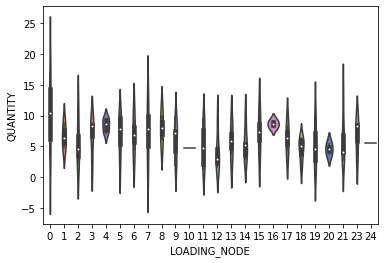

In [18]:
#violin chart of the number of clients served by each plant field
if all([field in movementColumns.keys() for field in ['clientfield','terminalfieldto']]):
    output_figure, output_df = violinPlantTerminal(D_mov,
                                                plantField=movementColumns['terminalfieldFrom'],
                                                clientField=movementColumns['clientfield'],
                                                capacityField=movementColumns['capacityField'])
    #salvo immagini
    for key in output_figure.keys():
            output_figure[key].savefig(current_path+f"\\{key}.png")
            
    # salvo dataframe
    for key in output_df.keys():
            output_df[key].to_excel(current_path+f"\\{key}.xlsx")
            display(HTML(output_df[key].to_html()))

## Vehicle analysis

Cartella Voyage Analysis già esistente
Cartella PROVISIONAL già esistente
Cartella CENSORED già esistente
**** DEFINISCO D MOV IN/OUT ****
**** DEFINISCO ROUTE  ****
**** RICOSTRUZIONE DEGLI INVENTARI  ****
==RICOSTRUISCO INVENTARIO VIAGGIO TRUCK 1, con 200 MOVIMENTI
Cartella COMPLETE già esistente
**** DEFINISCO D MOV IN/OUT ****
**** DEFINISCO ROUTE  ****
**** RICOSTRUZIONE DEGLI INVENTARI  ****
==RICOSTRUISCO INVENTARIO VIAGGIO TRUCK 1, con 184 MOVIMENTI
Cartella ACTUAL già esistente
Cartella CENSORED già esistente
**** DEFINISCO D MOV IN/OUT ****
**** DEFINISCO ROUTE  ****
**** RICOSTRUZIONE DEGLI INVENTARI  ****
==RICOSTRUISCO INVENTARIO VIAGGIO TRUCK 1, con 200 MOVIMENTI
Cartella COMPLETE già esistente
**** DEFINISCO D MOV IN/OUT ****
**** DEFINISCO ROUTE  ****
**** RICOSTRUZIONE DEGLI INVENTARI  ****
==RICOSTRUISCO INVENTARIO VIAGGIO TRUCK 1, con 184 MOVIMENTI


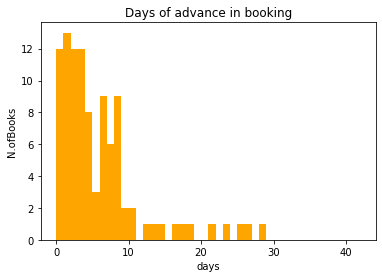

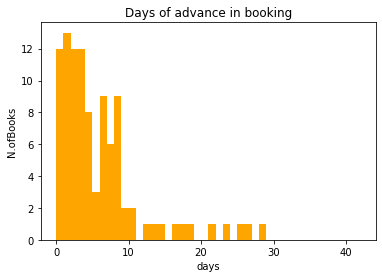

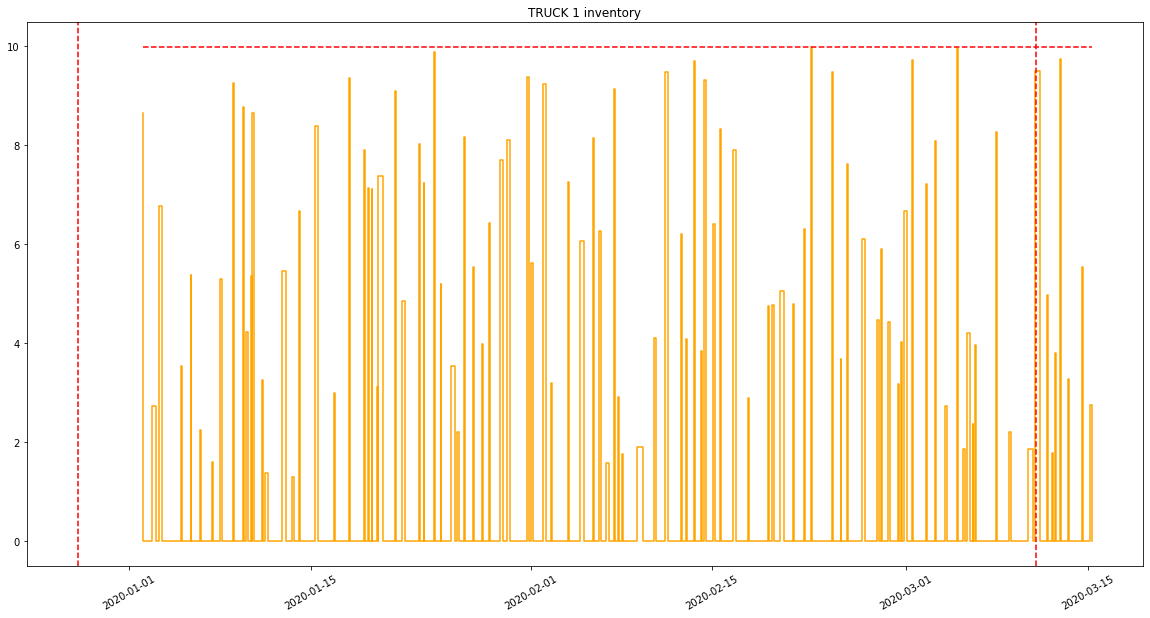

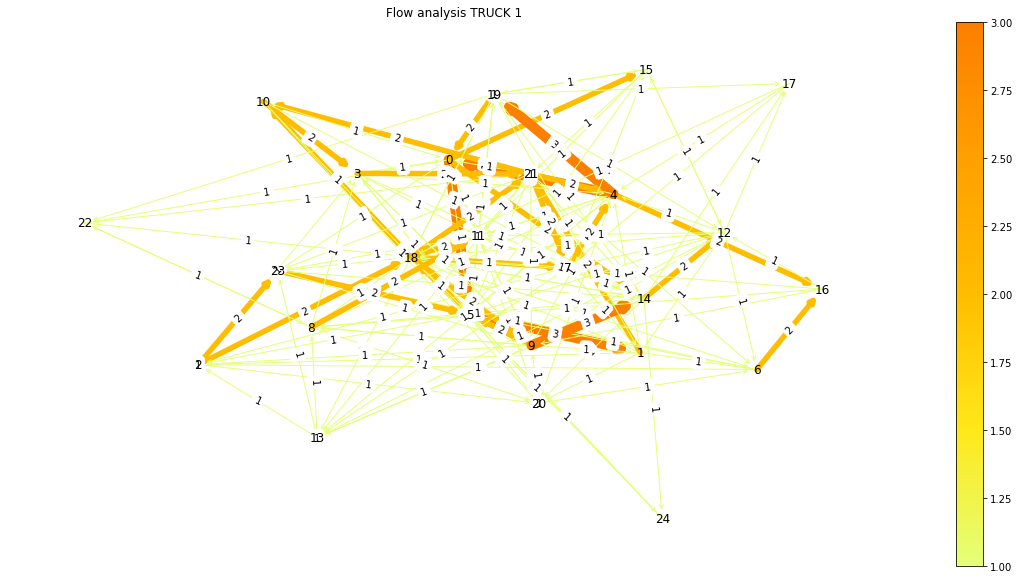

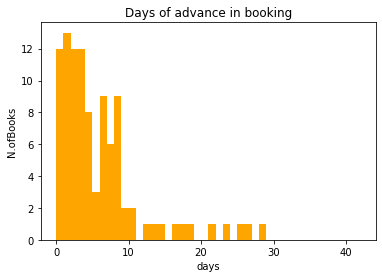

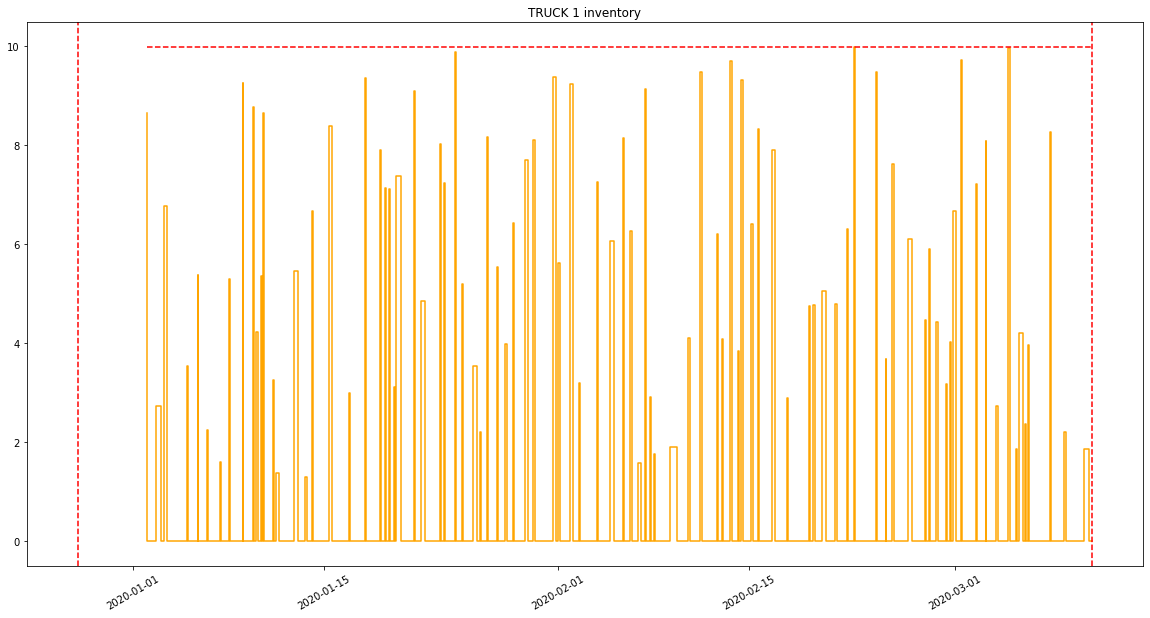

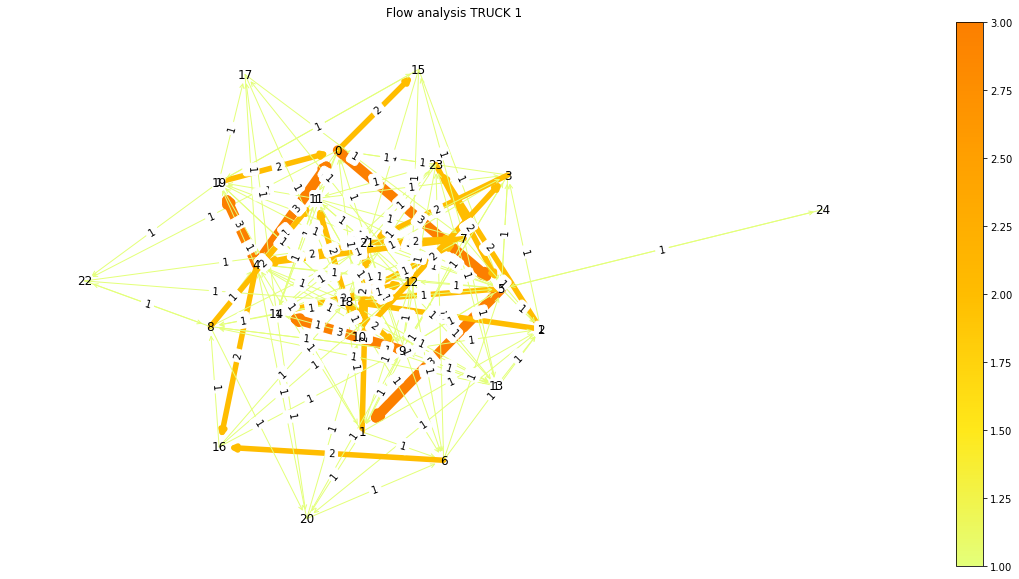

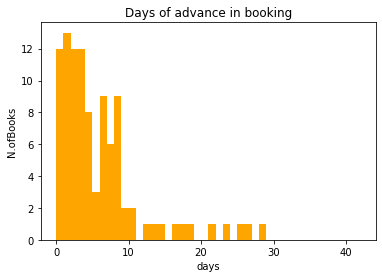

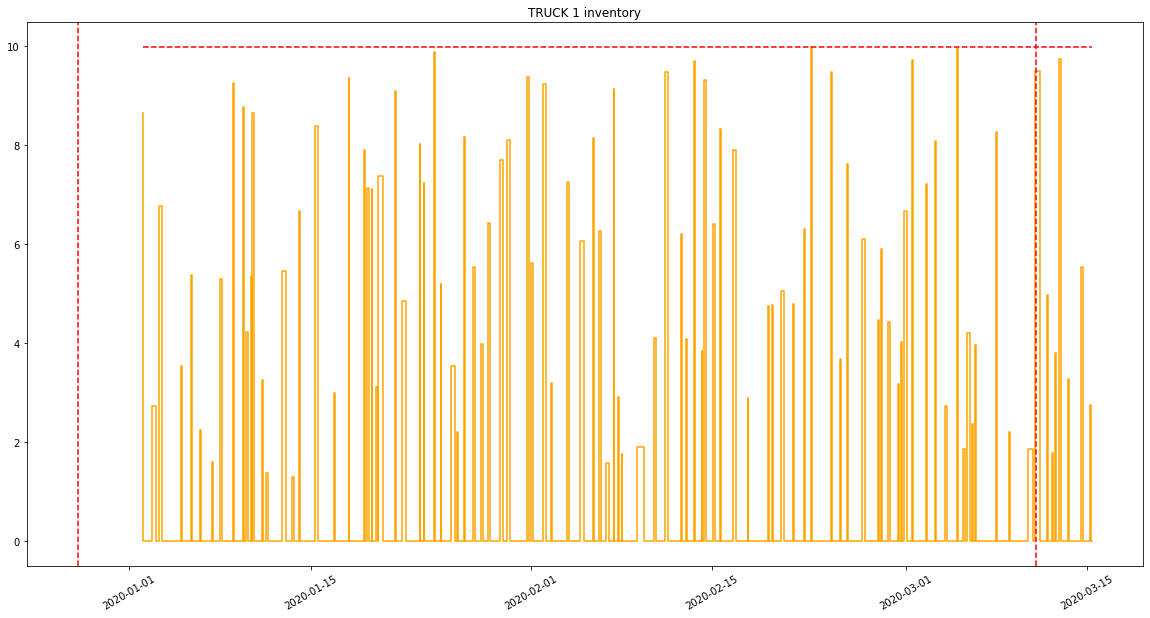

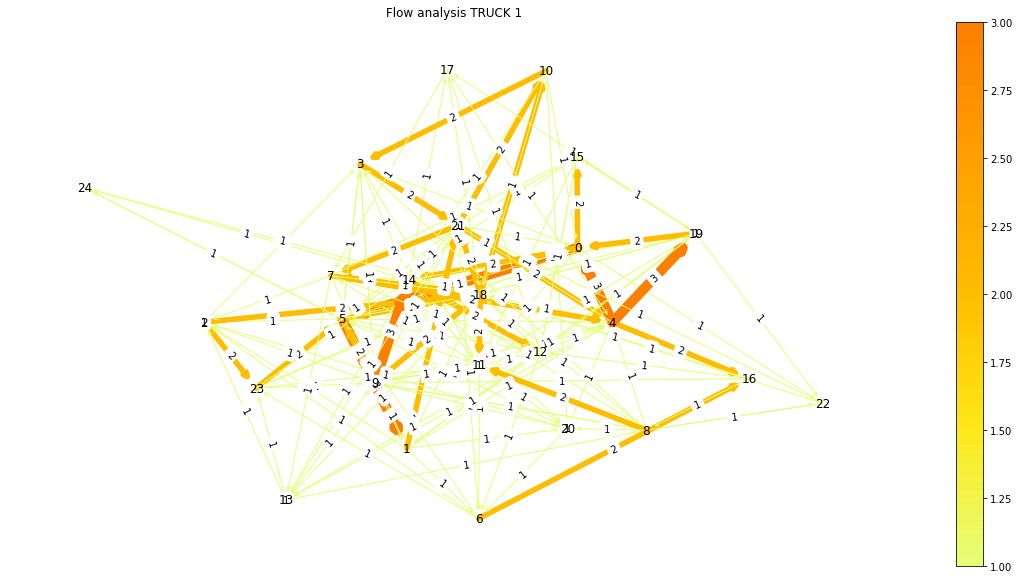

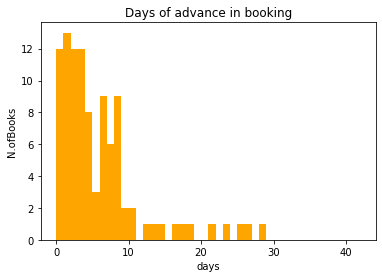

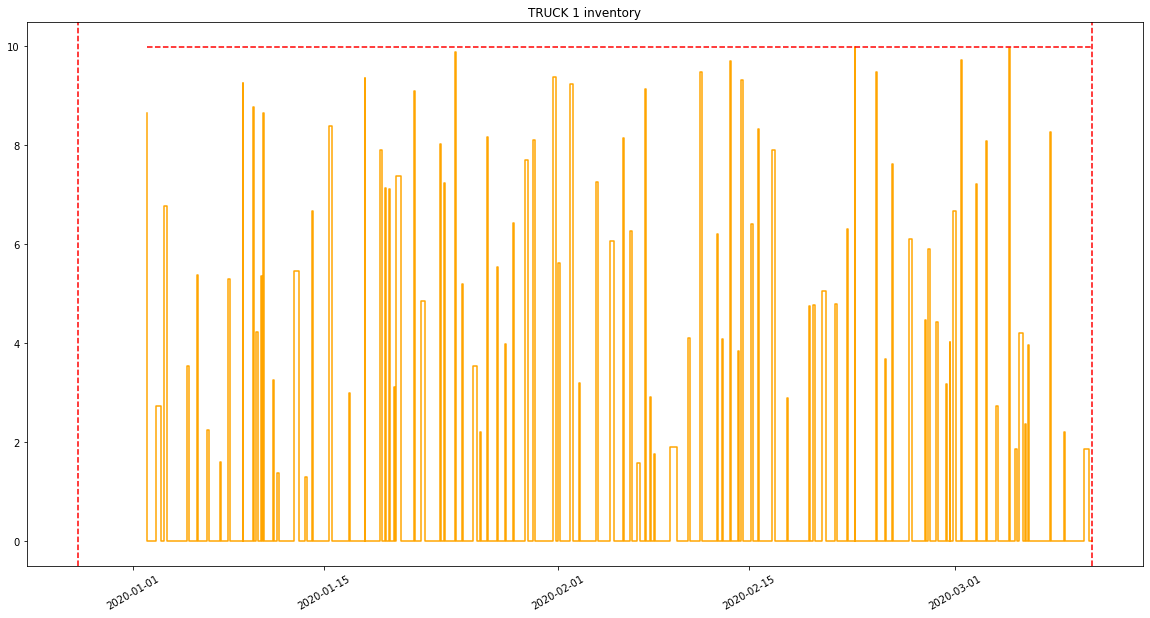

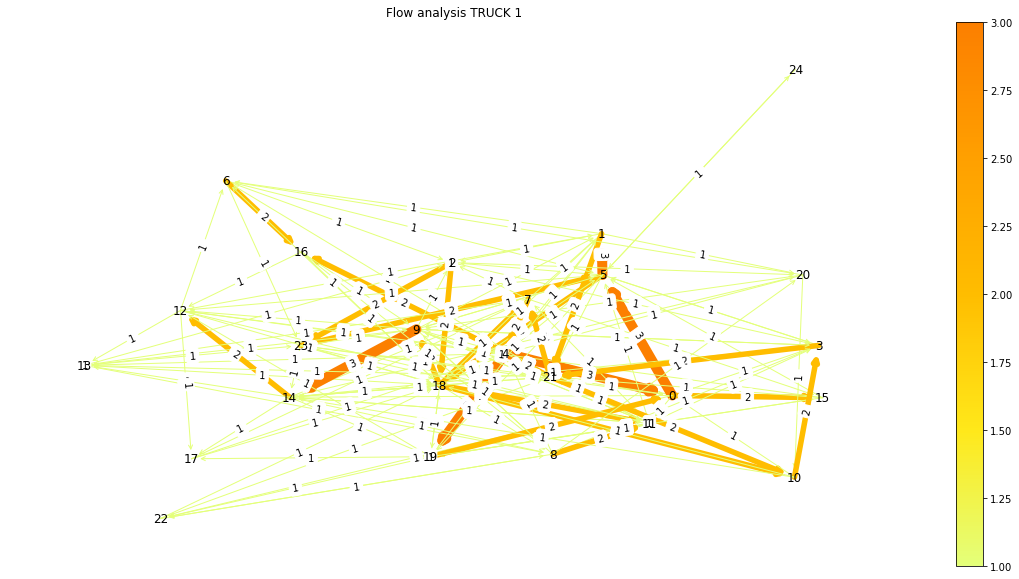

In [19]:
# %% VEHICLE STATISTICS
neededcolumns_time= ['loadingpta','loadingptd','dischargingpta', 
        'dischargingptd']
neededcolumns = ['terminalfieldFrom','terminalfieldto','capacityField']

if (all([field in movementColumns.keys() for field in neededcolumns]) &
    all([field in timeColumns.keys() for field in neededcolumns_time])): 
    # identifico estremi temporali dell'analisi
    firstPlanningDay=min(D_mov[movementColumns['timevariable']].dt.date)
    lastPlanningDay=max(D_mov[movementColumns['timevariable']].dt.date)
    _, df_advance  = getAdvanceInPlanning(D_mov,loadingptafield=timeColumns['loadingpta'])
    mean_advanceInPlanning=df_advance.loc['ADVANCE_PLANNING_MEAN']['VALUE']
    std_advanceInPlanning=df_advance.loc['ADVANCE_PLANNING_STD']['VALUE']
    lowerBoundDataCensored=firstPlanningDay+pd.Timedelta(days=(mean_advanceInPlanning+std_advanceInPlanning))
            
    
    _, current_path = creaCartella(path_results,f"Voyage Analysis")
    
    
    #verifico che dati ho a disposizione
    casiDaAnalizzare=[]
    if all([field in timeColumns.keys() for field in ['loadingpta','loadingptd','dischargingpta', 'dischargingptd' ]]): 
        casiDaAnalizzare.append('PROVISIONAL')
    if all([field in timeColumns.keys() for field in ['loadingata','loadingatd','dischargingata', 'dischargingatd' ]]): 
        casiDaAnalizzare.append('ACTUAL')

    for actual in casiDaAnalizzare:
        _, current_path_actual = creaCartella(current_path,f"{actual}")   
        
        for censored in ['CENSORED','COMPLETE']:
            
            if censored=='CENSORED': 
                censoredData=True
                _, current_path_censored = creaCartella(current_path_actual,f"CENSORED") 
            else:
                censoredData=False
                _, current_path_censored = creaCartella(current_path_actual,f"COMPLETE") 
            
            
        
        
            #ricostruisco le rotte
            D_route,  D_arcs_route, D_coverages  = D_voyageStatistics(     D_mov,
                                                timefield=movementColumns['timevariable'],
                                                locfrom = movementColumns['terminalfieldFrom'],
                                                locto= movementColumns['terminalfieldto'],
                                                timeColumns = timeColumns,
                                                capacityField=movementColumns['capacityField'],
                                                voyagefield =movementColumns['vehiclefield'],
                                                censoredData=censoredData,
                                                actual=actual)
            # salvo dataframe
            D_coverages.to_excel(current_path_censored+f"\\coverages.xlsx")  
            D_route.to_excel(current_path_censored+f"\\movementRoute.xlsx")    
            D_arcs_route.to_excel(current_path_censored+f"\\arcRoute.xlsx") 
                    
            if actual=='PROVISIONAL':
                sortTimefield='PTD'
            elif actual=='ACTUAL':
                sortTimefield='ATD'
            #salvo le immagini dei mezzi
            if len(D_route)>1:
                figure_results = returnFigureVoyage(D_route, D_arcs_route, 
                                                    lastPlanningDay=lastPlanningDay, lowerBoundDataCensored=lowerBoundDataCensored, 
                                                    filteringfield=movementColumns['vehiclefield'],
                                                    sortTimefield=sortTimefield)
                #salvo immagini
                for key in figure_results.keys():
                        figure_results[key].savefig(current_path_censored+f"\\{key}.png")

## Information analysis

In [20]:
neededcolumns_time= []
neededcolumns = ['clientfield','terminalfieldFrom','terminalfieldto','capacityField','vehiclefield']                
if (all([field in movementColumns.keys() for field in neededcolumns])):
               _, current_path = creaCartella(path_results,f"Information Analysis")
               
               outputfigure, output_df = paretoNodeClient(D_mov, 
                    clientfield=movementColumns['clientfield'], 
                    locationfromfield=movementColumns['terminalfieldFrom'],
                    locationtofield=movementColumns['terminalfieldto'],
                    vehiclefield=movementColumns['vehiclefield'],
                    capacityField=movementColumns['capacityField'],
                    )
    
               #salvo immagini
               for key in outputfigure.keys():
                        outputfigure[key].savefig(current_path+f"\\{key}.png")
                        
               # salvo dataframe
               for key in output_df.keys():
                    output_df[key].to_excel(current_path+f"\\{key}.xlsx")

Cartella Information Analysis già esistente
Same field for client and location from/to. Cannot proceed


## Terminal statistics

In [21]:
neededcolumns_time= ['loadingpta','loadingptd','dischargingpta', 
        'dischargingptd']
neededcolumns = ['terminalfieldFrom','terminalfieldto','capacityField']

if (all([field in movementColumns.keys() for field in neededcolumns]) &
    all([field in timeColumns.keys() for field in neededcolumns_time])): 
    
    _, current_path = creaCartella(path_results,f"Terminal Analysis")
    
    
    #verifico che dati ho a disposizione
    casiDaAnalizzare=[]
    if all([field in timeColumns.keys() for field in ['loadingpta','loadingptd','dischargingpta', 'dischargingptd' ]]): 
        casiDaAnalizzare.append('PROVISIONAL')
    if all([field in timeColumns.keys() for field in ['loadingata','loadingatd','dischargingata', 'dischargingatd' ]]): 
        casiDaAnalizzare.append('ACTUAL')
        
    for actual in casiDaAnalizzare:
        _, current_path_actual = creaCartella(current_path,f"{actual}")   
        
        for censored in ['CENSORED','COMPLETE']:
            
            if censored=='CENSORED': 
                censoredData=True
                _, current_path_censored = creaCartella(current_path_actual,f"CENSORED") 
            else:
                censoredData=False
                _, current_path_censored = creaCartella(current_path_actual,f"COMPLETE") 
            
            
        
        
            #ricostruisco le rotte
            outputfigure, D_terminal, D_coverages   = E_terminalStatistics(D_mov,
                                                                        timefield=movementColumns['timevariable'],
                                                                        locfrom = movementColumns['terminalfieldFrom'],                     
                                                                        locto= movementColumns['terminalfieldto'],
                                                                        voyagefield=movementColumns['vehiclefield'],
                                                                        capacityField=movementColumns['capacityField'],
                                                                        timeColumns=timeColumns,
                                                                        censoredData=censoredData,
                                                                        actual=actual,
                                                                        splitInOut=True)
            
            
            # salvo dataframe
            D_coverages.to_excel(current_path_censored+f"\\coverages.xlsx")  
            D_terminal.to_excel(current_path_censored+f"\\movementRoute.xlsx")    
            
            #salvo immagini
            for key in outputfigure.keys():
                if 'productivity_workload_network' in key:
                    _, networkPath = creaCartella(path_results,f"Network Analysis") 
                    outputfigure[key].savefig(networkPath+f"\\{key.replace('/','')}_{actual}_{censored}.png")
                
                else:
                    outputfigure[key].savefig(current_path_censored+f"\\{key.replace('/','')}.png")

Cartella Terminal Analysis già esistente
Cartella PROVISIONAL già esistente
Cartella CENSORED già esistente
**** DEFINISCO D MOV IN/OUT ****
**** DEFINISCO ROUTE  ****
**** DEFINISCO ROUTE  ****
Cartella Network Analysis già esistente
Cartella COMPLETE già esistente
**** DEFINISCO D MOV IN/OUT ****
**** DEFINISCO ROUTE  ****
**** DEFINISCO ROUTE  ****
Cartella Network Analysis già esistente
Cartella ACTUAL già esistente
Cartella CENSORED già esistente
**** DEFINISCO D MOV IN/OUT ****
**** DEFINISCO ROUTE  ****
**** DEFINISCO ROUTE  ****
Cartella Network Analysis già esistente
Cartella COMPLETE già esistente
**** DEFINISCO D MOV IN/OUT ****
**** DEFINISCO ROUTE  ****
**** DEFINISCO ROUTE  ****
Cartella Network Analysis già esistente


## Network statistics

Cartella Network Analysis già esistente
Cartella PROVISIONAL già esistente
Cartella ACTUAL già esistente


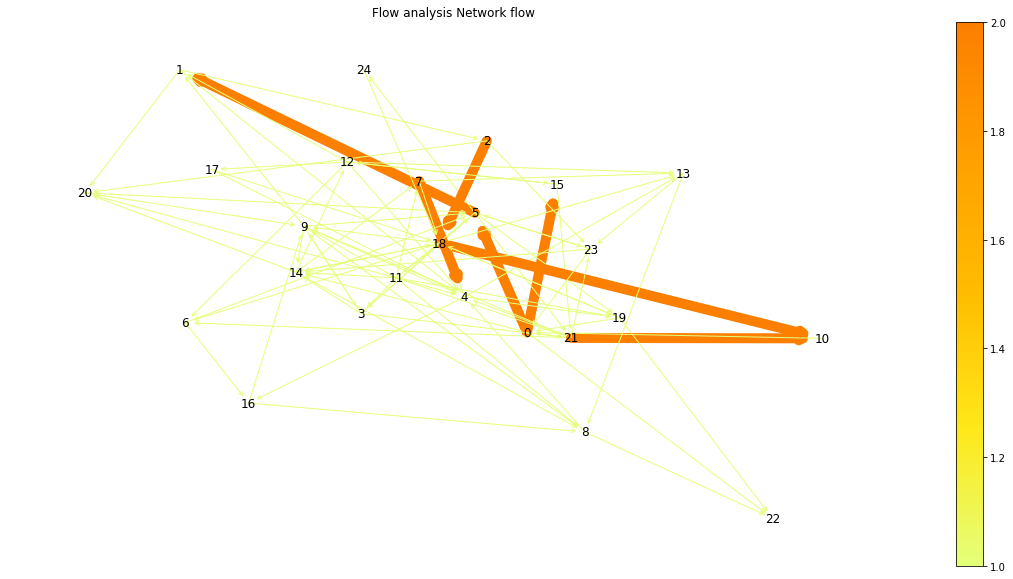

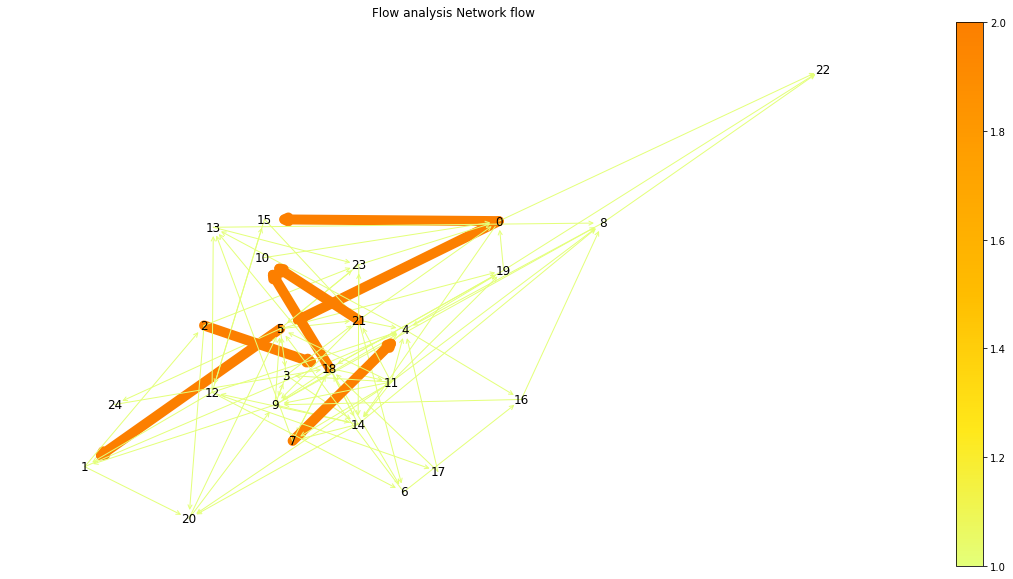

In [22]:
neededcolumns = ['terminalfieldFrom','terminalfieldto','capacityField']

if (all([field in movementColumns.keys() for field in neededcolumns])):
    
    _, current_path = creaCartella(path_results,f"Network Analysis")
    
    
    #verifico che dati ho a disposizione
    casiDaAnalizzare=[]
    if all([field in timeColumns.keys() for field in ['dischargingpta', 'loadingptd' ]]): 
        casiDaAnalizzare.append('PROVISIONAL')
    if all([field in timeColumns.keys() for field in ['dischargingata','loadingatd' ]]): 
        casiDaAnalizzare.append('ACTUAL')
        
    for actual in casiDaAnalizzare:
        _, current_path_actual = creaCartella(current_path,f"{actual}")   
                
        outputfigure, outptdf = F_networkStatistics(D_mov,
                                    terminalfieldFrom=movementColumns['terminalfieldFrom'],
                                    terminalfieldto=movementColumns['terminalfieldto'],
                                    capacityField=movementColumns['capacityField'],
                                    
                                    actual=actual,
                                    timeColumns=timeColumns)
        # salvo dataframe
        outptdf.to_excel(current_path_actual+f"\\graphData.xlsx")  
            
        
        #salvo immagini
        for key in outputfigure.keys():
             outputfigure[key].savefig(current_path_actual+f"\\{key}_{actual}_{censored}.png")

## Schedule statistics

Cartella Schedule Analysis già esistente
**** DEFINISCO D MOV IN/OUT ****


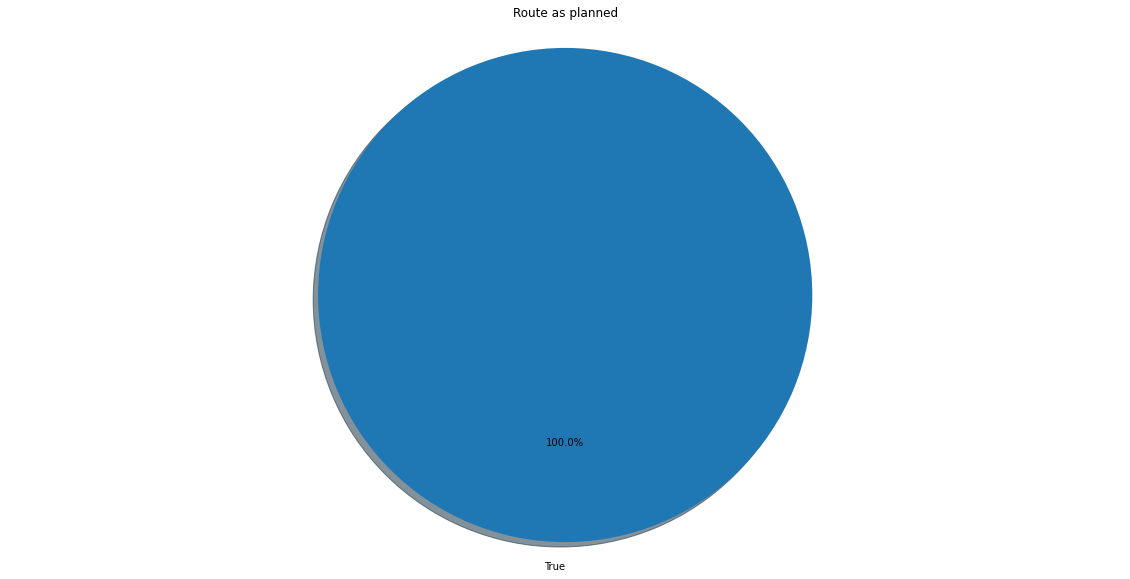

In [23]:
neededcolumns_time= ['loadingpta','loadingptd','dischargingpta','dischargingptd',
                     'loadingata','loadingatd','dischargingata','dischargingatd']
neededcolumns = ['terminalfieldFrom','terminalfieldto','capacityField','voyagefield','vehiclefield']             
if (all([field in movementColumns.keys() for field in neededcolumns]) &
    all([field in timeColumns.keys() for field in neededcolumns_time])): 
    
    _, current_path = creaCartella(path_results,f"Schedule Analysis")   
    output_figure, schedule_results =  checkPlannedActual(D_mov,
                                                          locfrom = movementColumns['terminalfieldFrom'],                    
                                                          locto= movementColumns['terminalfieldto'],
                                                          capacityField=movementColumns['capacityField'],
                                                          voyagefield =movementColumns['voyagefield'],
                                                          vehiclefield=movementColumns['vehiclefield'],
                                                          timeColumns=timeColumns)
    #salvo immagini
    for key in output_figure.keys():
         output_figure[key].savefig(current_path+f"\\{key}.png")
    
    #salvo dataframe
    for key in schedule_results.keys():
         schedule_results[key].to_excel(current_path+f"\\{key}.xlsx")  